Objective: Determine cost of running PyPSA simulation vs evaluating a trained ANN model on one sample

**Experimental Procedure**:

1. Time running a pf simulation with 1 data point
2. Train approximation models
3. Time evaluating models with 1 data point

**Hypothesis**: 

The time required to evaluate the models will be insignificant when compared to simulating one sample. To calculate 1 data point using the simulation the computer enlists a [Newton-Raphson (NR) root-finding algorithm](https://www.math.ubc.ca/~anstee/math104/newtonmethod.pdf),

x<sub>n+1</sub> = x<sub>n</sub> - $\frac{f(x_n)}{f'(x_n)}$,

as well as other miscellaneous PyPSA operations. The total cost being,

$time_{running-sim}$(f(x)) = time_NR_algorithm + time_PyPSA_related_operations.

It would be difficult to evaluate $time_{running-sim}$(f(x)) analytically, so an experimental result is used. Using simple speed tests for running a simulation on one sample (this sample requires 4 NR iterations),

$time_{running-sim}$(f(x)) = **3e-1 s**.



The math to evaluate an ANN model can be written in one line, and therefore an analytical estimate is presented. To evaluate an ANN model of four fully-connected layers (1 input [13 features], 2 hidden [sigmoid, 100 neurons per], 1 output [linear, 9 labels]) with one sample,

f(x) = weighted_sum_l1_l2 + evaluate_sigmoid_l2 + weighted_sum_l2_l3 + evaluate_sigmoid_l3 + weighted_sum_l3_l4

$time_{model-evaluation}$(f(x)) = 13 * 100 * C1 + 100 * C2 + 100 * 100 * C1 + 100 * C2 + 100 * 9 * C1 = 12100 * C1 + 200 * C2

Where, C1 is the cost of one multiplication operation and C2 is the cost of one logistic sigmoid evaluation. Basic speed tests set the values at C1 = 5e-8s, C2 = 2e-6s (using _scipy's expit_ function) so,

$time_{model-evaluation}$(f(x)) ~ 12100 * 5e-8 + 200 * 2e-6 = 6e-4 + 4e-4 = **1e-3 s**.


**In summary, model evaluation is expected to take two orders of magnitude less time than running a simulation**

**Results**:
* Single sample power flow simulation time: 0.3
* ann evaluation time: 0.0007
* svr evaluation time: 0.0006
* forest evaluation time: 0.002

**Discussion**:

The final result shows that running one simulation with one sample takes 0.3s or 428x the time of evaluating a model with one sample (0.0007s - ann).

The percent error between computed (0.0007) and predicted (0.001) time to evaluate an ANN model was 42%, with the computed value being faster than the predicted value. This is reasonable because computer usage was not controlled for in this experiment, and deviations of 100us can be expected if a computers' processors are in greater use.

Using these results an inference will be made to determine the cost of running the simulation 100 times vs running the simulation once, approximating the underlying model and evaluating the model (using the approximation) for the remaining 99 simulations. If the simulation is run 100x, it would take 30s. If the simulation is run once and then the approximation is evaluated the other 99x, it would take 0.3s. **The net result is a speed increase of 100x.**

This speed increase is the _highest_ possible outcome for the aforementioned inference. If the time to train the model is included, the speed increase multiplier will decrease because $time_{model} = time_{model-training} + time_{model-evaluation}$. There are two extreme $time_{model}$ scenarios that should be discussed. 

1. $time_{model-training} >> time_{model-evaluation}$ 

This scenario likely arises from a user using many data points to train their model, as well a the user sparsely evaluating that model. To compute the speed increase,

$speed~increase = \frac{time_{running-sim} \cdot n_{simulation}}{time_{model-training}}$

2. $time_{model-training} << time_{model-evaluation}$

This scenario likely arises from a user heavily leaning on their model to approximate answers. In this case, the speed increase is roughly **100x** as shown in _Discussion - paragraph 3_ .

To run a _simple speed test_ :

```python
st = time.time()
print("hi")
end = time.time()
_time = end-st_
```

Table of Contents:
* Power flow simulation
* Power flow approximation
  * Source data
  * Analyse data
  * Train models
  * Model Statistics Including Timing Evaluation

# Single sample power flow simulation

In [1]:
import pypsa
import time
import logging
import numpy as np
import warnings

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

import copy
import csv
import sys
import time

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.metrics import r2_score

import pypsa
from n_dimensional_datasets import *
from plotter import *

from IPython.display import display # for better Pandas printing

In [2]:
csv_folder_name = "/home/ubuntu/Downloads/pypsa/examples/ieee-13/ieee-13-with-load-gen-1-sample/"

network = pypsa.Network(import_name=csv_folder_name)

In [3]:
time_hold = []
for i in range(10):
    st = time.time()
    network.pf()
    end = time.time()
    time_hold.append(end-st)
print("Single sample power flow simulation time: {:.5}".format(np.mean(time_hold)))

Single sample power flow simulation time: 1.0648


In [4]:
network.buses_t.v_mag_pu

name,Substation,650,646,645,632,633,634,611,684,671,692,675,652,680
name,,,,,,,,,,,,,,
2011-01-01,1.0,0.965503,0.89708,0.900371,0.90997,0.90481,0.829759,0.864038,0.866397,0.870607,0.870589,0.863477,0.861953,0.870607


# Approximating Data

In [5]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name +  "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)

def collect_data(path_to_powerflow_data, data):
    '''
    Assumes folder tree has
    path_to_powerflow_data/
    -->datafiles
    -->results/
    '''
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "linemags.csv"), "linemag")
    
import pandas as pd
import numpy as np
    
def set_uniform_sample_size(path_to_powerflow_data, data_to_change, n_samples, seed=None):
    '''

    Parameters
    ----------
    data_to_change: list of strings.
        ex: ["loads-p_set", "generators-p_max_pu", "snapshots"] 
    '''

    data = {}
    for datatype in data_to_change:
        data[datatype] = pd.read_csv(path_to_powerflow_data + datatype + ".csv")

    def increase_data(dataframe, n_samples, seed=None):
        addon = {}
        new_df_list = []
        for idx, column in enumerate(dataframe):
          
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                ## special cases
                if datatype == "generators-p_max_pu":
                    # add a ridiculous amount of generation so the is always enough power and sim doesn't fail
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=100, high=200, size=n_samples)
                elif datatype == "snapshots":
                    addon[column] = np.ones(n_samples)
                else:
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=0, high=0.5, size=n_samples)
            elif dataframe[column].dtype == object:
                # assuming object is datetime column
                latest_datetime = pd.to_datetime(dataframe[column][0])
                addon[column] = []
                for sample in range(n_samples):
                    addon[column].append(latest_datetime + pd.Timedelta(hours=(1+sample)))
            else:
                raise TypeError("dataframe[column] type: {} should be object or float64/int64".format(
                    type(dataframe[column].dtype)))
        addon_dataframe = pd.DataFrame(addon)
        return dataframe.head(1).append(addon_dataframe)

    for datatype in data:
        data[datatype] = increase_data(data[datatype], n_samples-1, seed) # -1 is for original sample, which stays
        data[datatype].to_csv(path_to_powerflow_data + datatype + ".csv", index=False)
        print("Datatype {} stored".format(datatype))

def create_samples_and_run_network():
    '''
    assuming all required variables in this function are global and previously defined. Yes lazy I know
    '''
    set_uniform_sample_size(path_to_powerflow_data, data_to_change, sample_size, seed=None)

    network = pypsa.Network(import_name=path_to_powerflow_data)
    network.pf()

    save_path = path_to_powerflow_data + "results/"
    network.buses_t.v_mag_pu.to_csv(save_path + "vmags.csv")
    network.buses_t.v_ang.to_csv(save_path + "vangs.csv")
    network.buses_t.q.to_csv(save_path + "qmags.csv")
    network.lines_t.p0.to_csv(save_path + "linemags.csv")
    
def backup_samples(src, dest):
    '''
    thanks https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/
    '''
    import os
    import errno
    import shutil
    
    try:
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.copytree(src, dest)
        print("Backup to {} successful".format(dest))
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)

## Source Data

In [6]:
## USER INPUT
sample_size = 1000000

data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example +
                          "/ieee-13-with-load-gen-uniform-data-"
                          + str(sample_size) +
                          "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"

In [7]:
## Uncomment to generate load samples for modified IEEE-13 network
# if sample_size > 10000:
#     user = input("Are you sure [y/n]? This could erase hours worth of data")
#     if user == "y":
#         backup_samples(path_to_powerflow_results, path_to_powerflow_data + "results-backup/")
#         create_samples_and_run_network()
# else:
#     create_samples_and_run_network()

data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(path_to_powerflow_data, data)

### Analyse Data

In [8]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1) #loc[:,["vmag-632", "vmag-671", "vmag-675"]]
features_and_labels = features.join(labels)

,vmag-650,vmag-646,vmag-645,vmag-632,vmag-633,vmag-634,vmag-611,vmag-684,vmag-671,vmag-692,vmag-675,vmag-652,vmag-680
vmag-650,1.000000,0.129211,0.137423,0.158581,0.151580,0.152913,0.128939,0.133763,0.140260,0.140251,0.137634,0.121992,0.140260
vmag-646,0.129211,1.000000,0.989636,0.871763,0.834089,0.833978,0.685177,0.710346,0.750538,0.750498,0.737576,0.646591,0.750538
vmag-645,0.137423,0.989636,1.000000,0.912196,0.876103,0.875995,0.735572,0.761130,0.800632,0.800593,0.787946,0.695768,0.800632
vmag-632,0.158581,0.871763,0.912196,1.000000,0.977497,0.977419,0.903295,0.927248,0.957247,0.957225,0.947824,0.862605,0.957247
vmag-633,0.151580,0.834089,0.876103,0.977497,1.000000,0.999991,0.853538,0.878228,0.911606,0.911578,0.901049,0.812968,0.911606
vmag-634,0.152913,0.833978,0.875995,0.977419,0.999991,1.000000,0.853404,0.878094,0.911478,0.911450,0.900919,0.812835,0.911478
vmag-611,0.128939,0.685177,0.735572,0.903295,0.853538,0.853404,1.000000,0.992859,0.966666,0.966636,0.955417,0.952115,0.966666
vmag-684,0.133763,0.710346,0.761130,0.927248,0.878228,0.878094,0.992859,1.000000,0.985273,0.985252,0.975925,0.969216,0.985273
vmag-671,0.140260,0.750538,0.800632,0.957247,0.911606,0.911478,0.966666,0.985273,1.000000,1.000000,0.995711,0.930705,1.000000
vmag-692,0.140251,0.750498,0.800593,0.957225,0.911578,0.911450,0.966636,0.985252,1.000000,1.000000,0.995726,0.930667,1.000000


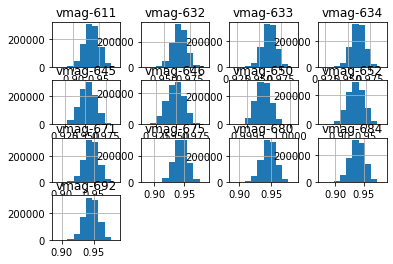

In [9]:
labels.hist()
labels.corr()

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611
load-632,1.000000,-0.000996,0.001461,-0.001329,0.000874,-0.001166,-0.001239,0.000354,0.000186
load-634,-0.000996,1.000000,0.001498,-0.000389,0.001122,0.000494,0.000252,-0.000083,-0.001206
load-645,0.001461,0.001498,1.000000,0.000438,0.000464,-0.000651,0.000211,-0.000634,0.000231
load-646,-0.001329,-0.000389,0.000438,1.000000,0.000619,0.000651,-0.001152,0.000873,0.000703
load-652,0.000874,0.001122,0.000464,0.000619,1.000000,-0.001082,-0.000184,-0.001545,-0.001305
load-671,-0.001166,0.000494,-0.000651,0.000651,-0.001082,1.000000,0.000629,-0.000970,0.001455
load-675,-0.001239,0.000252,0.000211,-0.001152,-0.000184,0.000629,1.000000,0.001064,-0.002619
load-692,0.000354,-0.000083,-0.000634,0.000873,-0.001545,-0.000970,0.001064,1.000000,0.002284
load-611,0.000186,-0.001206,0.000231,0.000703,-0.001305,0.001455,-0.002619,0.002284,1.000000


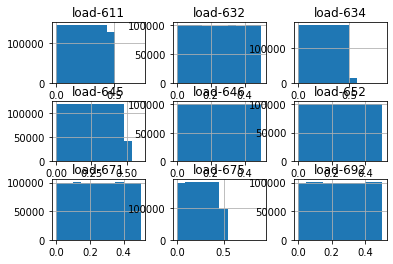

In [10]:
features.hist()
features.corr()

In [11]:
corr_matrix = labels.join(features).corr()

# only loads for columns
cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
reduced_corr_matrix = corr_matrix[cols]
reduced_corr_matrix["row average"] = pd.Series(reduced_corr_matrix.mean(axis=1))
# only voltages for rows
rows = reduced_corr_matrix.index[reduced_corr_matrix.index.str.contains("load")]
reduced_corr_matrix.drop(rows, inplace=True)
reduced_corr_matrix = reduced_corr_matrix.append(pd.Series(reduced_corr_matrix.mean(), name="column average"))

display(reduced_corr_matrix)

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vmag-650,-0.002975,-0.001960,-0.004645,-0.003313,-0.005674,-0.005303,-0.004597,-0.002558,-0.005723,-0.004083
vmag-646,-0.197076,-0.199118,-0.493050,-0.667383,-0.212260,-0.205422,-0.205144,-0.205851,-0.210414,-0.288413
vmag-645,-0.220994,-0.223130,-0.552184,-0.554559,-0.237614,-0.230010,-0.230018,-0.230423,-0.235555,-0.301610
vmag-632,-0.317876,-0.320451,-0.326884,-0.327726,-0.341181,-0.330928,-0.331288,-0.331305,-0.338362,-0.329556
vmag-633,-0.287571,-0.511894,-0.296310,-0.296619,-0.309179,-0.299743,-0.300047,-0.299886,-0.306140,-0.323043
vmag-634,-0.287491,-0.511754,-0.296234,-0.296535,-0.309099,-0.299664,-0.299974,-0.299794,-0.306067,-0.322957
vmag-611,-0.157468,-0.158510,-0.161818,-0.162686,-0.464996,-0.318669,-0.318177,-0.319119,-0.599139,-0.295620
vmag-684,-0.170499,-0.171885,-0.175257,-0.176116,-0.503864,-0.344959,-0.345041,-0.345332,-0.500129,-0.303676
vmag-671,-0.197725,-0.199562,-0.203385,-0.204272,-0.412090,-0.400454,-0.401135,-0.400818,-0.409311,-0.314306
vmag-692,-0.197691,-0.199528,-0.203350,-0.204237,-0.412019,-0.400385,-0.401278,-0.400960,-0.409241,-0.314299


## Train Models

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import LinearNDInterpolator
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from custom_transformers import DataFrameSelector, RejectOutliers
from sklearn.decomposition import PCA
from scoring import rmse

In [ ]:
training_percentage = 80
n_samples = 100000
n_training_samples = int(n_samples*(training_percentage/100))

# random_seed=None
X_train, X_val, y_train, y_val, test_idx, train_idx = train_test_split(features,
                                                                       labels,
                                                                       range(100000),
                                                                       train_size=n_training_samples,
                                                                       test_size=n_samples-n_training_samples,
                                                                       random_state=None)
X_train = X_train.values
y_train = y_train.values
X_val = X_val.values
y_val = y_val.values

In [ ]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

In [ ]:
training_stats = {"n_training_samples": n_training_samples,
                  "n_validation_samples": n_samples-n_training_samples,
                  "n_features": X_train.shape[1],
                  "n_labels": y_train.shape[1],
                  "interp_run": False}
stats = {"trainscore": [], 
         "trainscorevar": [],
         "valscore": [],
         "valscorevar": [],
         "rmse": [],
         "time": []}
approx_type = {"svr": copy.deepcopy(stats),
               "rf": copy.deepcopy(stats),
               "ann": copy.deepcopy(stats),
               "interp": copy.deepcopy(stats),
               "linear": copy.deepcopy(stats)}
approx_type["interp"].pop("trainscorevar")
approx_type["interp"].pop("valscorevar")
approx_type["linear"].pop("trainscorevar")
approx_type["linear"].pop("valscorevar")

time_start = time.time()
### setup approximators


## random forest
forest = RandomForestRegressor()

forest_xval_training_score = cross_val_score(forest, X_train, y_train, cv=5, n_jobs=-1, scoring=make_scorer(r2_score))
forest_xval_val_score = cross_val_score(forest, X_val, y_val, cv=5, n_jobs=-1, scoring=make_scorer(r2_score))
approx_type["rf"]["trainscore"].append(forest_xval_training_score.mean())
approx_type["rf"]["trainscorevar"].append(forest_xval_training_score.std())
approx_type["rf"]["valscore"].append(forest_xval_val_score.mean())
approx_type["rf"]["valscorevar"].append(forest_xval_val_score.std())

forest.fit(X_train, y_train)
approx_type["rf"]["rmse"].append(rmse(forest.predict(X_val), y_val))

time_forest = time.time()
approx_type["rf"]["time"].append(time_forest-time_start)

                                
## support vector regression
if n_samples <= 10000:
    n_labels = y_train.shape[1]
    svr = copy.deepcopy(stats)
    svr_labels = {"y_train": None, "y_val": None}
    for idx in range(n_labels):
        svr_labels["y_train"] = y_train.T[idx].T
        svr_labels["y_val"] = y_val.T[idx].T
        clf = SVR(gamma='scale', C=1.0, epsilon=0.0002, kernel='rbf')
        '''
        Scikit-Learn cross-validation features expect a utility function (greater is better) rather than a cost function
        (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), 
        which is why the preceding code computes -scores before calculating the square root.
        - A. Geron, Hands on Machine Learning pg 101 
        '''
        svr_xval_training_score = cross_val_score(clf, X_train, svr_labels["y_train"], cv=5, n_jobs=-1, scoring=make_scorer(r2_score))
        svr_xval_val_score = cross_val_score(clf, X_val, svr_labels["y_val"], cv=5, n_jobs=-1, scoring=make_scorer(r2_score))
        svr["trainscore"].append(svr_xval_training_score.mean())
        svr["trainscorevar"].append(svr_xval_training_score.std())
        svr["valscore"].append(svr_xval_val_score.mean())
        svr["valscorevar"].append(svr_xval_val_score.std())

        clf.fit(X_train, svr_labels["y_train"])
        svr["rmse"].append(rmse(clf.predict(X_val), svr_labels["y_val"]))

        time_svr = time.time()
        svr["time"].append(time_svr - time_forest)

        if idx == (n_labels-1):
            display("rmse: ", svr["rmse"])
            label_results = pd.DataFrame(columns=labels.columns)
            label_results.loc[0] = svr["trainscore"]
            display(label_results)

    approx_type["svr"]["trainscore"].append(np.mean(svr["trainscore"]))
    approx_type["svr"]["trainscorevar"].append(np.mean(svr["trainscorevar"]))
    approx_type["svr"]["valscore"].append(np.mean(svr["valscore"]))
    approx_type["svr"]["valscorevar"].append(np.mean(svr["valscorevar"]))
    approx_type["svr"]["rmse"].append(np.mean(svr["rmse"]))
    approx_type["svr"]["time"].append(np.mean(svr["time"]))


## ann
hidden_layer_size = 100
ann = MLPRegressor(hidden_layer_sizes=(hidden_layer_size, hidden_layer_size),
                   activation="logistic",
                   solver="adam",
                   alpha=0.000001,
                   learning_rate_init=1e-5,
                   max_iter=100000,
                   n_iter_no_change=100,
                   tol=1e-9,
                  )

ann_xval_training_score = cross_val_score(ann, X_train, y_train, cv=5, n_jobs=-1, scoring=make_scorer(r2_score))
ann_xval_val_score = cross_val_score(ann, X_val, y_val, cv=5, n_jobs=-1, scoring=make_scorer(r2_score))
approx_type["ann"]["trainscore"].append(ann_xval_training_score.mean())
approx_type["ann"]["trainscorevar"].append(ann_xval_training_score.std())
approx_type["ann"]["valscore"].append(ann_xval_val_score.mean())
approx_type["ann"]["valscorevar"].append(ann_xval_val_score.std())
print("\n\nANN training scores: {}\n\n val scores: {}".format(ann_xval_training_score, ann_xval_val_score))

ann.fit(X_train, y_train)
approx_type["ann"]["rmse"].append(rmse(ann.predict(X_val), y_val))

time_ann = time.time()
approx_type["ann"]["time"].append(time_ann-time_svr)


## interpolation
# interp training gets very slow as the number of features grows
if X_train.shape[1] < 4:
    training_stats["interp_run"] = True
    interp = LinearNDInterpolator(X_train, y_train, fill_value=0)

    time_interp = time.time()
    approx_type["interp"]["time"].append(time_interp-time_ann)

    approx_type["interp"]["trainscore"].append(r2_score(y_train, interp(X_train)))
    approx_type["interp"]["valscore"].append(r2_score(y_val, interp(X_val)))
    approx_type["interp"]["rmse"].append(rmse(interp(X_val), y_val))
    
## linear regression
linear = LinearRegression()
linear.fit(X_train, y_train)

time_linear = time.time()
try:
    approx_type["linear"]["time"].append(time_linear-time_interp)
except:
    approx_type["linear"]["time"].append(time_linear-time_ann)

approx_type["linear"]["trainscore"].append(r2_score(y_train, linear.predict(X_train)))
approx_type["linear"]["valscore"].append(r2_score(y_val, linear.predict(X_val)))
approx_type["linear"]["rmse"].append(rmse(linear.predict(X_val), y_val))    

## Model Statistics Including Timing Evaluation

In [ ]:
## print and save stats
import csv
import datetime
datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
print("Training Stats\n\n{}".format(pd.DataFrame(training_stats, index=[0])))
for t in approx_type:        
    print("\n", t + " Stats: \n")
    results_to_save = pd.DataFrame(approx_type[t]).round(3)
    display(results_to_save)
    results_to_save.to_csv("model_results/{}-{}_samples-resuls-{}.csv".format(t, n_samples, datetimestamp))
    
# with open("results-{}_samples-{}.csv".format(datetimestamp), 'w') as f:
#     for key in approx_type:
#         f.write("%s,%s\n"%(key, value))

if n_samples <= 10000:
    print("svr training score - non crossvalidation: ", r2_score(svr_labels["y_train"], clf.predict(X_train)))
    print("svr validation score - non crossvalidation: ", r2_score(svr_labels["y_val"], clf.predict(X_val)))
print("rf training score - non crossvalidation: ", r2_score(y_train, forest.predict(X_train)))
print("rf validation score - non crossvalidation: ", r2_score(y_val, forest.predict(X_val)))
print("ann training score - non crossvalidation: ", r2_score(y_train, ann.predict(X_train)))
print("ann validation score - non crossvalidation: ", r2_score(y_val, ann.predict(X_val)))

In [ ]:
ann_evaluation_time_start = time.time()
ann.predict(X_val[0].reshape(1,9))
ann_evaluation_time_stop = time.time()
print("ANN evaluation time: {:.5}".format(ann_evaluation_time_stop-ann_evaluation_time_start))

svr_evaluation_time_start = time.time()
clf.predict(X_val[0].reshape(1,9))
svr_evaluation_time_stop = time.time()
print("svr evaluation time: {:.5}".format(svr_evaluation_time_stop-svr_evaluation_time_start))

forest_evaluation_time_start = time.time()
forest.predict(X_val[0].reshape(1,9))
forest_evaluation_time_stop = time.time()
print("forest evaluation time: {:.5}".format(forest_evaluation_time_stop-forest_evaluation_time_start))